Starting training...
Epoch 1/10 - 3.14s - loss: 2.3041 - acc: 0.1316 - val_loss: 2.2987 - val_acc: 0.1687
Epoch 2/10 - 4.21s - loss: 2.2094 - acc: 0.1571 - val_loss: 1.8762 - val_acc: 0.2658
Epoch 3/10 - 1.95s - loss: 1.3537 - acc: 0.4581 - val_loss: 1.0940 - val_acc: 0.5503
Epoch 4/10 - 1.95s - loss: 0.9744 - acc: 0.6203 - val_loss: 0.8997 - val_acc: 0.6592
Epoch 5/10 - 1.96s - loss: 0.8542 - acc: 0.6745 - val_loss: 0.8389 - val_acc: 0.6810
Epoch 6/10 - 1.98s - loss: 0.8020 - acc: 0.7045 - val_loss: 0.7696 - val_acc: 0.7270
Epoch 7/10 - 4.70s - loss: 0.7655 - acc: 0.7224 - val_loss: 0.7631 - val_acc: 0.7155
Epoch 8/10 - 1.99s - loss: 0.7293 - acc: 0.7418 - val_loss: 0.6995 - val_acc: 0.7570
Epoch 9/10 - 1.99s - loss: 0.6902 - acc: 0.7559 - val_loss: 0.6587 - val_acc: 0.7718
Epoch 10/10 - 1.99s - loss: 0.6479 - acc: 0.7691 - val_loss: 0.6167 - val_acc: 0.7863

Test Loss: 0.6436
Test Accuracy: 0.7689
Macro-average Precision: 0.7673
Macro-average Recall: 0.7689
Macro-average F1 Score: 0.

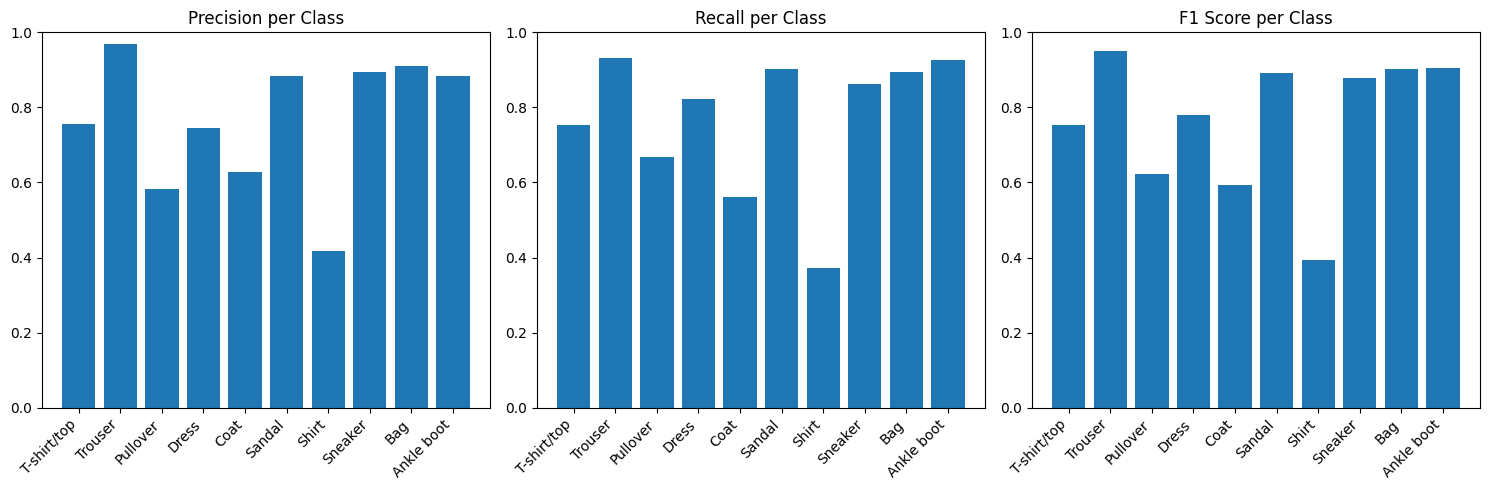

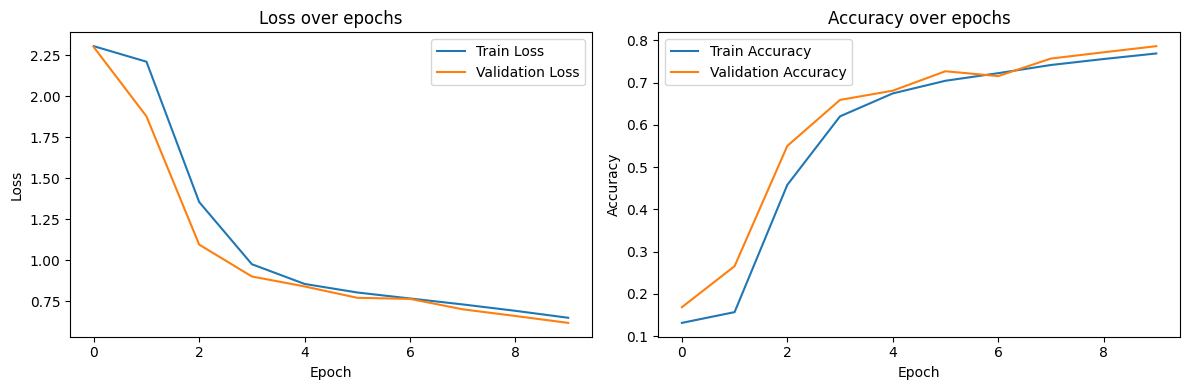

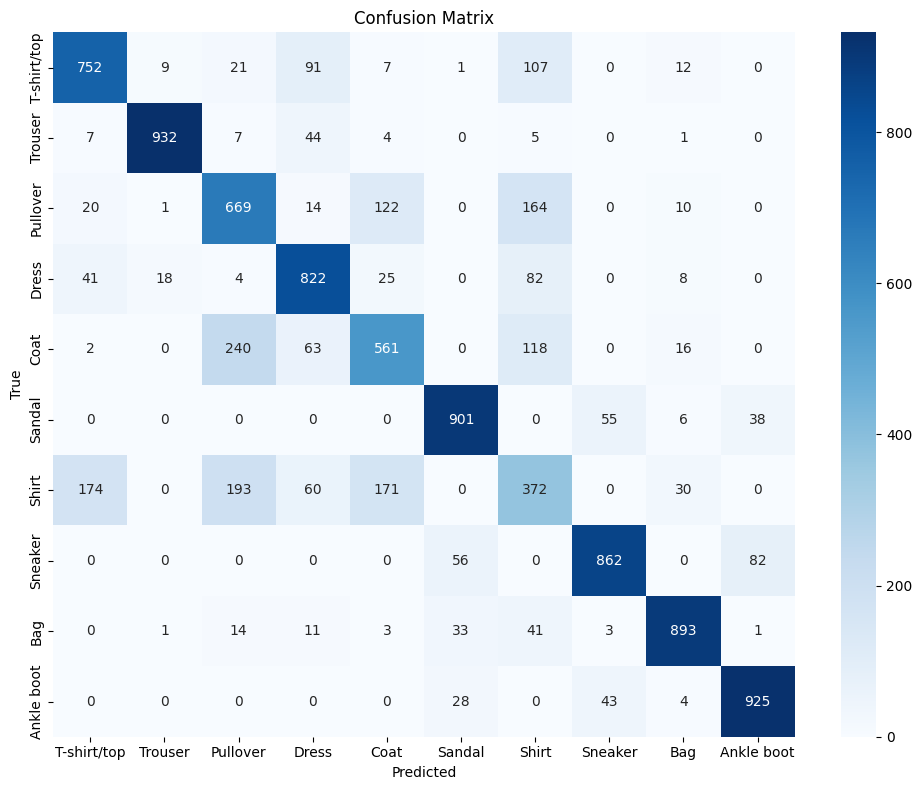

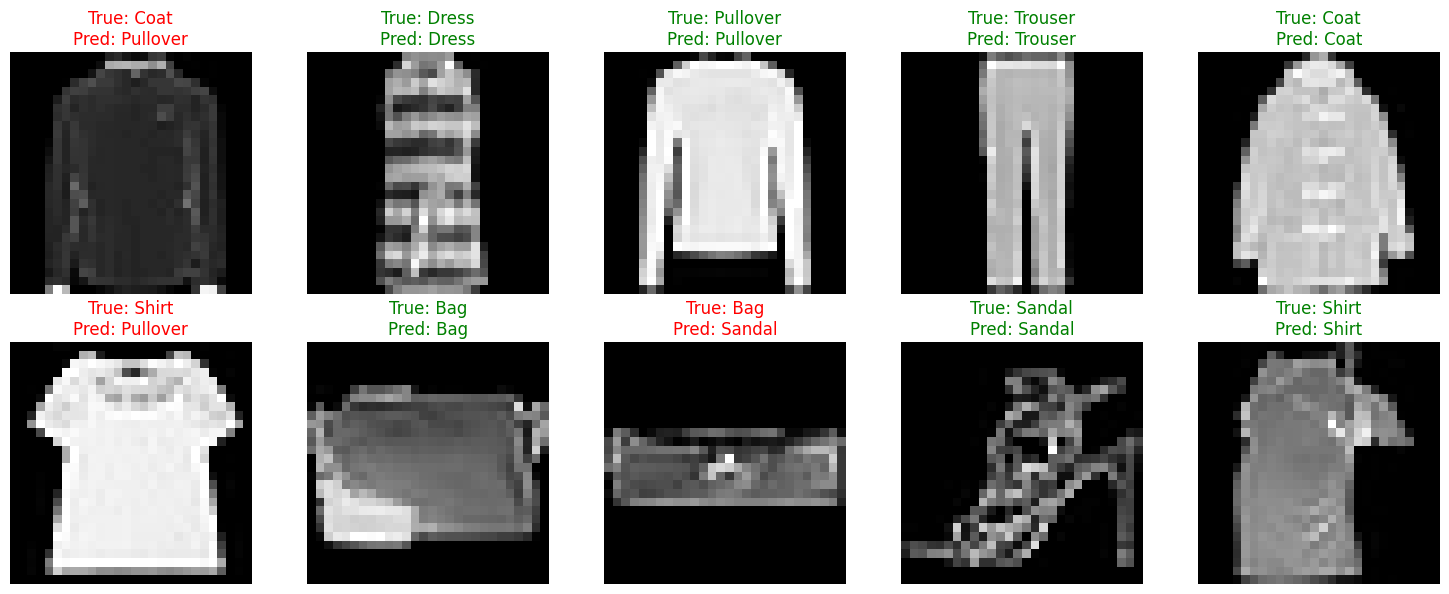

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import time

# Set random seed for reproducibility
np.random.seed(42)

# Load Fashion MNIST dataset using Keras
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Preprocess the data
# Normalize pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape images to vectors
X_train = X_train.reshape(X_train.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)

# One-hot encode the labels
def to_one_hot(y, num_classes=10):
    y_one_hot = np.zeros((len(y), num_classes))
    y_one_hot[np.arange(len(y)), y] = 1
    return y_one_hot

y_train_one_hot = to_one_hot(y_train)
y_test_one_hot = to_one_hot(y_test)

# Activation functions and their derivatives
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))  # Clip to avoid overflow

def sigmoid_derivative(x):
    return x * (1 - x)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1.0, 0.0)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # For numerical stability
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# MLP Class from scratch
class MLP:
    def __init__(self, input_size, hidden_sizes, output_size, activation='relu'):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size

        # Initialize weights and biases
        self.parameters = {}

        # Input layer to first hidden layer
        self.parameters['W1'] = np.random.randn(input_size, hidden_sizes[0]) * 0.01
        self.parameters['b1'] = np.zeros((1, hidden_sizes[0]))

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.parameters[f'W{i+1}'] = np.random.randn(hidden_sizes[i-1], hidden_sizes[i]) * 0.01
            self.parameters[f'b{i+1}'] = np.zeros((1, hidden_sizes[i]))

        # Last hidden layer to output layer
        self.parameters[f'W{len(hidden_sizes)+1}'] = np.random.randn(hidden_sizes[-1], output_size) * 0.01
        self.parameters[f'b{len(hidden_sizes)+1}'] = np.zeros((1, output_size))

        # Set activation function
        if activation == 'relu':
            self.activation = relu
            self.activation_derivative = relu_derivative
        else:  # Default to sigmoid
            self.activation = sigmoid
            self.activation_derivative = sigmoid_derivative

        # Store activations and pre-activations for backpropagation
        self.activations = {}
        self.pre_activations = {}

    def forward(self, X):
        self.activations['A0'] = X

        # Input layer to first hidden layer
        self.pre_activations['Z1'] = np.dot(X, self.parameters['W1']) + self.parameters['b1']
        self.activations['A1'] = self.activation(self.pre_activations['Z1'])

        # Hidden layers
        for i in range(2, len(self.hidden_sizes) + 2):
            self.pre_activations[f'Z{i}'] = np.dot(self.activations[f'A{i-1}'], self.parameters[f'W{i}']) + self.parameters[f'b{i}']
            if i == len(self.hidden_sizes) + 1:  # Output layer
                self.activations[f'A{i}'] = softmax(self.pre_activations[f'Z{i}'])
            else:  # Hidden layers
                self.activations[f'A{i}'] = self.activation(self.pre_activations[f'Z{i}'])

        return self.activations[f'A{len(self.hidden_sizes) + 1}']

    def backward(self, X, y, learning_rate):
        m = X.shape[0]
        n_layers = len(self.hidden_sizes) + 1

        # Output layer error
        dZ = self.activations[f'A{n_layers}'] - y

        # Initialize gradients
        gradients = {}

        # Output layer gradients
        gradients[f'dW{n_layers}'] = np.dot(self.activations[f'A{n_layers-1}'].T, dZ) / m
        gradients[f'db{n_layers}'] = np.sum(dZ, axis=0, keepdims=True) / m

        # Hidden layers gradients
        for i in range(n_layers - 1, 0, -1):
            dA = np.dot(dZ, self.parameters[f'W{i+1}'].T)
            if i == 0:  # Input layer
                dZ = dA
            else:  # Hidden layers
                dZ = dA * self.activation_derivative(self.activations[f'A{i}'])

            gradients[f'dW{i}'] = np.dot(self.activations[f'A{i-1}'].T, dZ) / m
            gradients[f'db{i}'] = np.sum(dZ, axis=0, keepdims=True) / m

        # Update parameters
        for i in range(1, n_layers + 1):
            self.parameters[f'W{i}'] -= learning_rate * gradients[f'dW{i}']
            self.parameters[f'b{i}'] -= learning_rate * gradients[f'db{i}']

    def train(self, X, y, epochs, batch_size, learning_rate, X_val=None, y_val=None):
        m = X.shape[0]
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

        for epoch in range(epochs):
            epoch_start_time = time.time()
            # Shuffle training data
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            loss = 0
            correct = 0

            # Mini-batch training
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                # Forward pass
                y_pred = self.forward(X_batch)

                # Compute loss
                batch_loss = -np.sum(y_batch * np.log(y_pred + 1e-8)) / X_batch.shape[0]
                loss += batch_loss

                # Compute accuracy
                batch_correct = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))
                correct += batch_correct

                # Backward pass
                self.backward(X_batch, y_batch, learning_rate)

            # Average loss and accuracy for the epoch
            loss /= (m // batch_size)
            accuracy = correct / m

            history['train_loss'].append(loss)
            history['train_acc'].append(accuracy)

            # Validation
            if X_val is not None and y_val is not None:
                val_pred = self.forward(X_val)
                val_loss = -np.sum(y_val * np.log(val_pred + 1e-8)) / X_val.shape[0]
                val_acc = np.sum(np.argmax(val_pred, axis=1) == np.argmax(y_val, axis=1)) / X_val.shape[0]

                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)

                epoch_time = time.time() - epoch_start_time
                print(f"Epoch {epoch+1}/{epochs} - {epoch_time:.2f}s - loss: {loss:.4f} - acc: {accuracy:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")
            else:
                epoch_time = time.time() - epoch_start_time
                print(f"Epoch {epoch+1}/{epochs} - {epoch_time:.2f}s - loss: {loss:.4f} - acc: {accuracy:.4f}")

        return history

    def predict(self, X):
        """Make predictions using the trained model"""
        predictions = self.forward(X)
        return np.argmax(predictions, axis=1)

    def evaluate(self, X, y, y_original=None):
        """Evaluate the model on test data with additional metrics"""
        y_pred_probs = self.forward(X)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(y, axis=1) if y_original is None else y_original

        # Calculate basic metrics
        loss = -np.sum(y * np.log(y_pred_probs + 1e-8)) / X.shape[0]
        accuracy = np.sum(y_pred == y_true) / X.shape[0]

        # Calculate precision, recall and F1 score for each class
        precision = precision_score(y_true, y_pred, average=None)
        recall = recall_score(y_true, y_pred, average=None)
        f1 = f1_score(y_true, y_pred, average=None)

        # Calculate macro averages (unweighted mean)
        macro_precision = precision_score(y_true, y_pred, average='macro')
        macro_recall = recall_score(y_true, y_pred, average='macro')
        macro_f1 = f1_score(y_true, y_pred, average='macro')

        # Calculate weighted averages (weighted by support)
        weighted_precision = precision_score(y_true, y_pred, average='weighted')
        weighted_recall = recall_score(y_true, y_pred, average='weighted')
        weighted_f1 = f1_score(y_true, y_pred, average='weighted')

        # Store all metrics
        metrics = {
            'loss': loss,
            'accuracy': accuracy,
            'class_precision': precision,
            'class_recall': recall,
            'class_f1': f1,
            'macro_precision': macro_precision,
            'macro_recall': macro_recall,
            'macro_f1': macro_f1,
            'weighted_precision': weighted_precision,
            'weighted_recall': weighted_recall,
            'weighted_f1': weighted_f1
        }

        return metrics, y_pred

# Create and train the model
input_size = 28 * 28
hidden_sizes = [128, 64]  # Two hidden layers
output_size = 10  # 10 classes for Fashion MNIST

# Create the model
model = MLP(input_size, hidden_sizes, output_size, activation='relu')

# Split training data into training and validation sets
# Use 10% of the training data for validation
val_size = int(0.1 * X_train.shape[0])
X_val = X_train[:val_size]
y_val_one_hot = y_train_one_hot[:val_size]
y_val_original = y_train[:val_size]
X_train_sub = X_train[val_size:]
y_train_one_hot_sub = y_train_one_hot[val_size:]
y_train_original_sub = y_train[val_size:]

# Train the model
batch_size = 64
learning_rate = 0.01
epochs = 10

print("Starting training...")
history = model.train(X_train_sub, y_train_one_hot_sub, epochs, batch_size, learning_rate,
                     X_val, y_val_one_hot)

# Evaluate on test set with comprehensive metrics
test_metrics, y_pred = model.evaluate(X_test, y_test_one_hot, y_test)

print(f"\nTest Loss: {test_metrics['loss']:.4f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Macro-average Precision: {test_metrics['macro_precision']:.4f}")
print(f"Macro-average Recall: {test_metrics['macro_recall']:.4f}")
print(f"Macro-average F1 Score: {test_metrics['macro_f1']:.4f}")
print(f"Weighted-average Precision: {test_metrics['weighted_precision']:.4f}")
print(f"Weighted-average Recall: {test_metrics['weighted_recall']:.4f}")
print(f"Weighted-average F1 Score: {test_metrics['weighted_f1']:.4f}")

# Print detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# Plot metrics per class
plt.figure(figsize=(15, 5))

# Plot precision per class
plt.subplot(1, 3, 1)
plt.bar(class_names, test_metrics['class_precision'])
plt.title('Precision per Class')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

# Plot recall per class
plt.subplot(1, 3, 2)
plt.bar(class_names, test_metrics['class_recall'])
plt.title('Recall per Class')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

# Plot F1 score per class
plt.subplot(1, 3, 3)
plt.bar(class_names, test_metrics['class_f1'])
plt.title('F1 Score per Class')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Visualize some predictions
def plot_predictions(X, y_true, y_pred, indices, class_names):
    """Plot some predictions with true and predicted labels"""
    num_images = len(indices)
    rows = int(np.ceil(num_images / 5))
    cols = min(5, num_images)

    plt.figure(figsize=(15, 3 * rows))

    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)
        img = X[idx].reshape(28, 28)
        plt.imshow(img, cmap='gray')

        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]

        title_color = 'green' if y_true[idx] == y_pred[idx] else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Randomly select 10 test images to visualize
indices = np.random.choice(len(X_test), 10, replace=False)
plot_predictions(X_test, y_test, y_pred, indices, class_names)

Starting training...
Epoch 1/15 - 6.02s - loss: 0.9549 - acc: 0.6669 - val_loss: 0.5308 - val_acc: 0.8172
Epoch 2/15 - 5.33s - loss: 0.5018 - acc: 0.8237 - val_loss: 0.4550 - val_acc: 0.8402
Epoch 3/15 - 7.71s - loss: 0.4344 - acc: 0.8442 - val_loss: 0.4037 - val_acc: 0.8610
Epoch 4/15 - 5.16s - loss: 0.3951 - acc: 0.8576 - val_loss: 0.3702 - val_acc: 0.8667
Epoch 5/15 - 7.66s - loss: 0.3661 - acc: 0.8671 - val_loss: 0.3648 - val_acc: 0.8668
Epoch 6/15 - 5.15s - loss: 0.3469 - acc: 0.8742 - val_loss: 0.3499 - val_acc: 0.8722
Epoch 7/15 - 7.66s - loss: 0.3313 - acc: 0.8772 - val_loss: 0.3601 - val_acc: 0.8700
Epoch 8/15 - 5.23s - loss: 0.3159 - acc: 0.8844 - val_loss: 0.3256 - val_acc: 0.8820
Epoch 9/15 - 7.56s - loss: 0.3039 - acc: 0.8873 - val_loss: 0.3316 - val_acc: 0.8777
Epoch 10/15 - 5.12s - loss: 0.2924 - acc: 0.8926 - val_loss: 0.3307 - val_acc: 0.8815
Epoch 11/15 - 7.61s - loss: 0.2820 - acc: 0.8966 - val_loss: 0.3354 - val_acc: 0.8773
Epoch 12/15 - 5.14s - loss: 0.2717 - acc: 

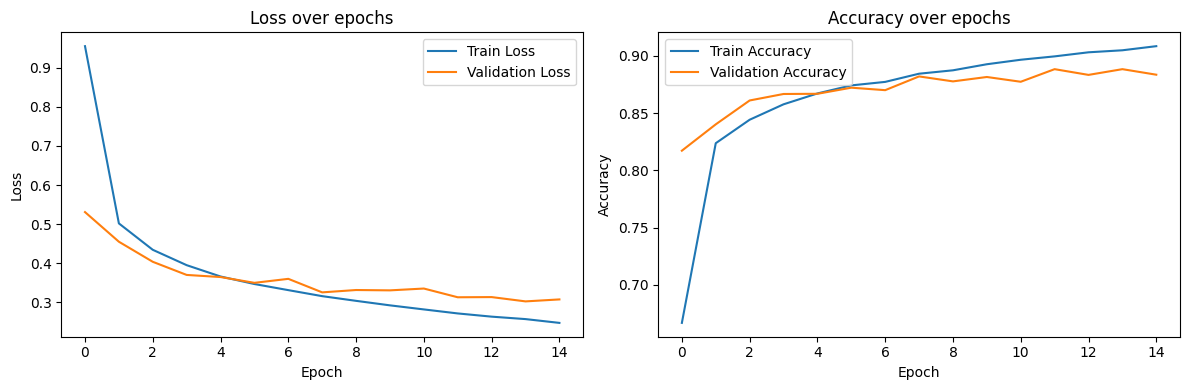

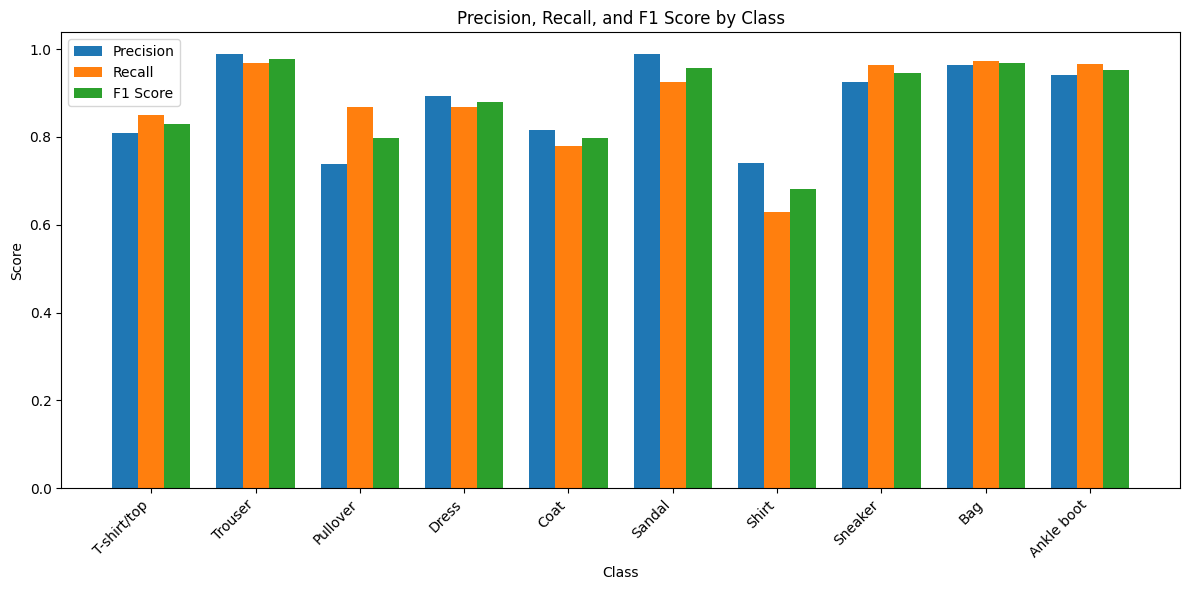

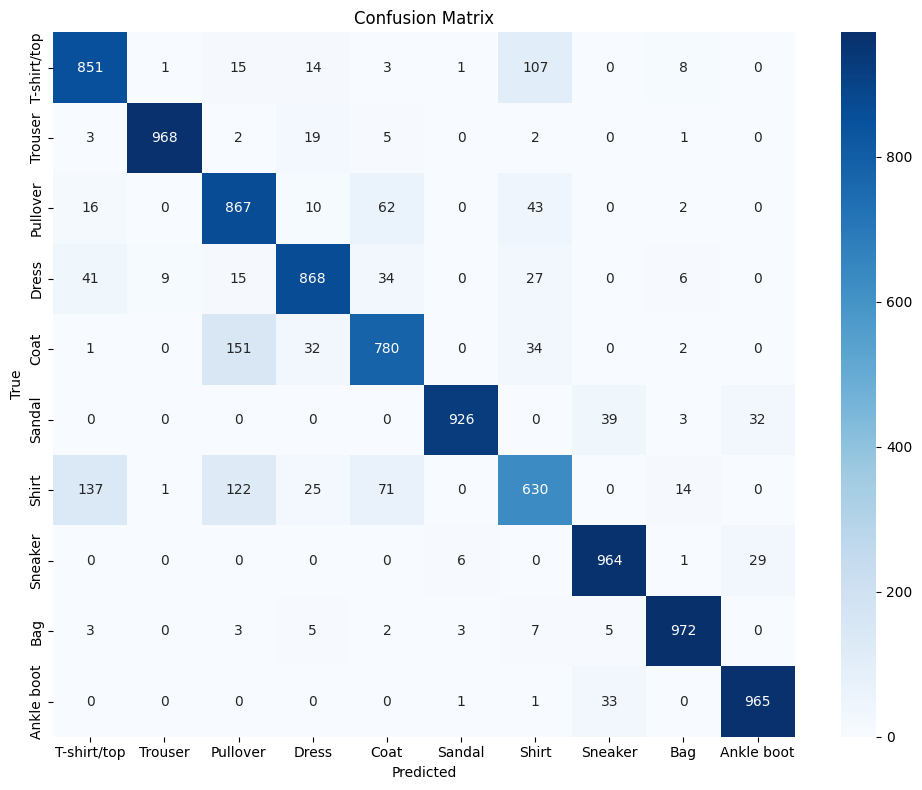

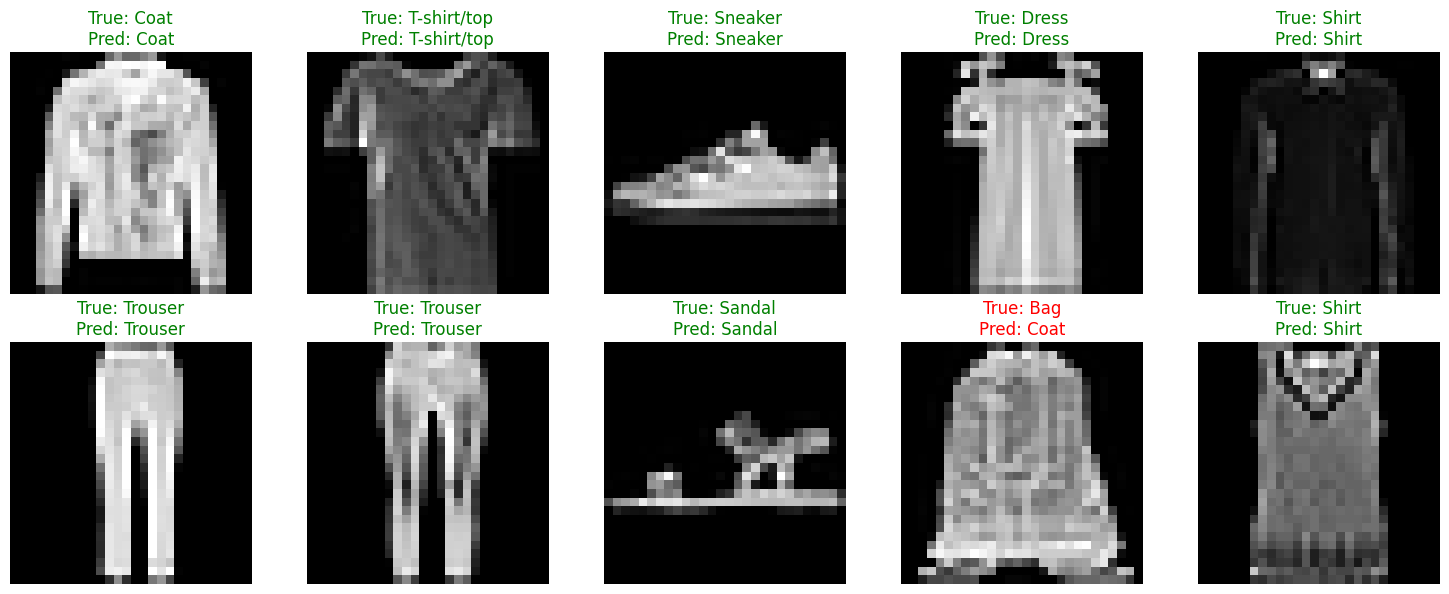


Found 1209 misclassified examples


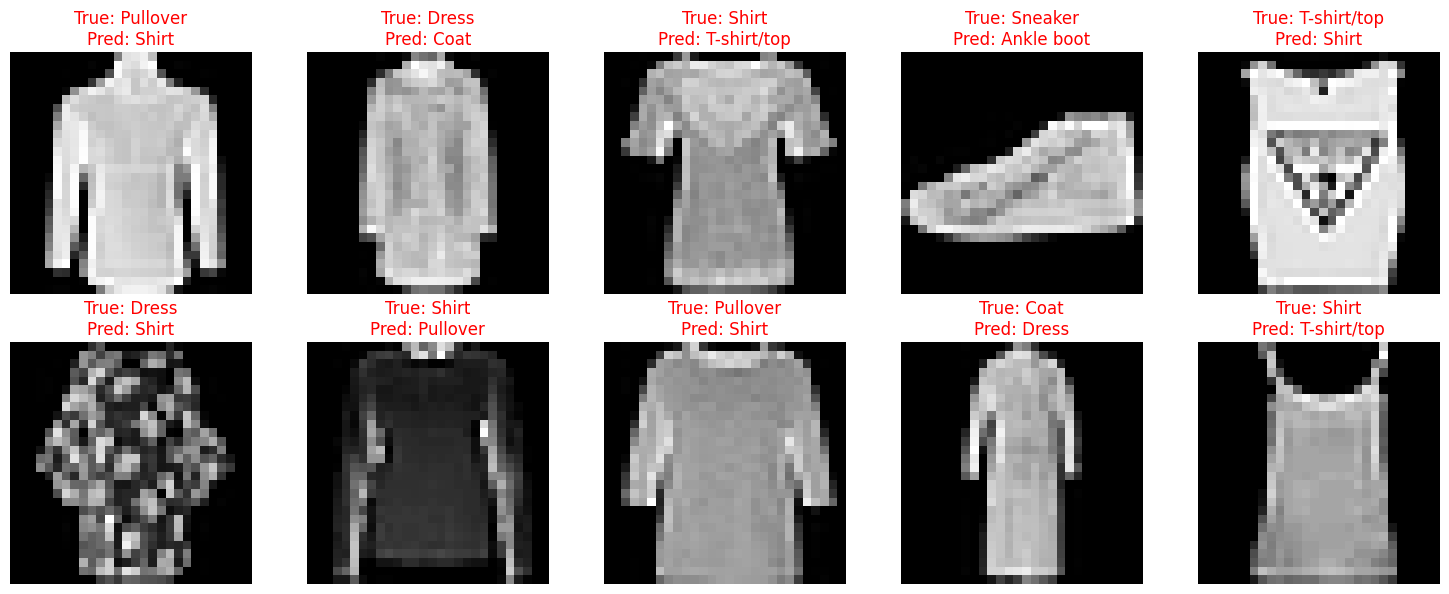


===== Most Common Misclassifications =====
Coat misclassified as Pullover: 151 times
Shirt misclassified as T-shirt/top: 137 times
Shirt misclassified as Pullover: 122 times
T-shirt/top misclassified as Shirt: 107 times
Shirt misclassified as Coat: 71 times


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report
import time

# Set random seed for reproducibility
np.random.seed(42)

# Load Fashion MNIST dataset using Keras
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Preprocess the data
# Normalize pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape images to vectors
X_train = X_train.reshape(X_train.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)

# One-hot encode the labels
def to_one_hot(y, num_classes=10):
    y_one_hot = np.zeros((len(y), num_classes))
    y_one_hot[np.arange(len(y)), y] = 1
    return y_one_hot

y_train_one_hot = to_one_hot(y_train)
y_test_one_hot = to_one_hot(y_test)

# Activation functions and their derivatives
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))  # Clip to avoid overflow

def sigmoid_derivative(x):
    return x * (1 - x)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1.0, 0.0)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # For numerical stability
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# MLP Class from scratch
class MLP:
    def __init__(self, input_size, hidden_sizes, output_size, activation='relu', weight_init_scale=0.01):
        # MODIFIED: Added weight_init_scale parameter to control weight initialization
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size

        # Initialize weights and biases
        self.parameters = {}

        # Input layer to first hidden layer
        self.parameters['W1'] = np.random.randn(input_size, hidden_sizes[0]) * weight_init_scale
        self.parameters['b1'] = np.zeros((1, hidden_sizes[0]))

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            self.parameters[f'W{i+1}'] = np.random.randn(hidden_sizes[i-1], hidden_sizes[i]) * weight_init_scale
            self.parameters[f'b{i+1}'] = np.zeros((1, hidden_sizes[i]))

        # Last hidden layer to output layer
        self.parameters[f'W{len(hidden_sizes)+1}'] = np.random.randn(hidden_sizes[-1], output_size) * weight_init_scale
        self.parameters[f'b{len(hidden_sizes)+1}'] = np.zeros((1, output_size))

        # Set activation function
        if activation == 'relu':
            self.activation = relu
            self.activation_derivative = relu_derivative
        else:  # Default to sigmoid
            self.activation = sigmoid
            self.activation_derivative = sigmoid_derivative

        # Store activations and pre-activations for backpropagation
        self.activations = {}
        self.pre_activations = {}

    def forward(self, X):
        self.activations['A0'] = X

        # Input layer to first hidden layer
        self.pre_activations['Z1'] = np.dot(X, self.parameters['W1']) + self.parameters['b1']
        self.activations['A1'] = self.activation(self.pre_activations['Z1'])

        # Hidden layers
        for i in range(2, len(self.hidden_sizes) + 2):
            self.pre_activations[f'Z{i}'] = np.dot(self.activations[f'A{i-1}'], self.parameters[f'W{i}']) + self.parameters[f'b{i}']
            if i == len(self.hidden_sizes) + 1:  # Output layer
                self.activations[f'A{i}'] = softmax(self.pre_activations[f'Z{i}'])
            else:  # Hidden layers
                self.activations[f'A{i}'] = self.activation(self.pre_activations[f'Z{i}'])

        return self.activations[f'A{len(self.hidden_sizes) + 1}']

    def backward(self, X, y, learning_rate, momentum=0.9):
        # MODIFIED: Added momentum to gradient descent
        m = X.shape[0]
        n_layers = len(self.hidden_sizes) + 1

        # Initialize velocity if it doesn't exist
        if not hasattr(self, 'velocity'):
            self.velocity = {}
            for i in range(1, n_layers + 1):
                self.velocity[f'dW{i}'] = np.zeros_like(self.parameters[f'W{i}'])
                self.velocity[f'db{i}'] = np.zeros_like(self.parameters[f'b{i}'])

        # Output layer error
        dZ = self.activations[f'A{n_layers}'] - y

        # Initialize gradients
        gradients = {}

        # Output layer gradients
        gradients[f'dW{n_layers}'] = np.dot(self.activations[f'A{n_layers-1}'].T, dZ) / m
        gradients[f'db{n_layers}'] = np.sum(dZ, axis=0, keepdims=True) / m

        # Hidden layers gradients
        for i in range(n_layers - 1, 0, -1):
            dA = np.dot(dZ, self.parameters[f'W{i+1}'].T)
            if i == 0:  # Input layer
                dZ = dA
            else:  # Hidden layers
                dZ = dA * self.activation_derivative(self.activations[f'A{i}'])

            gradients[f'dW{i}'] = np.dot(self.activations[f'A{i-1}'].T, dZ) / m
            gradients[f'db{i}'] = np.sum(dZ, axis=0, keepdims=True) / m

        # Update parameters with momentum
        for i in range(1, n_layers + 1):
            self.velocity[f'dW{i}'] = momentum * self.velocity[f'dW{i}'] + learning_rate * gradients[f'dW{i}']
            self.velocity[f'db{i}'] = momentum * self.velocity[f'db{i}'] + learning_rate * gradients[f'db{i}']

            self.parameters[f'W{i}'] -= self.velocity[f'dW{i}']
            self.parameters[f'b{i}'] -= self.velocity[f'db{i}']

    def train(self, X, y, epochs, batch_size, learning_rate, X_val=None, y_val=None):
        m = X.shape[0]
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

        for epoch in range(epochs):
            epoch_start_time = time.time()
            # Shuffle training data
            indices = np.random.permutation(m)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            loss = 0
            correct = 0

            # Mini-batch training
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                # Forward pass
                y_pred = self.forward(X_batch)

                # Compute loss
                batch_loss = -np.sum(y_batch * np.log(y_pred + 1e-8)) / X_batch.shape[0]
                loss += batch_loss

                # Compute accuracy
                batch_correct = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))
                correct += batch_correct

                # Backward pass
                self.backward(X_batch, y_batch, learning_rate)

            # Average loss and accuracy for the epoch
            loss /= (m // batch_size)
            accuracy = correct / m

            history['train_loss'].append(loss)
            history['train_acc'].append(accuracy)

            # Validation
            if X_val is not None and y_val is not None:
                val_pred = self.forward(X_val)
                val_loss = -np.sum(y_val * np.log(val_pred + 1e-8)) / X_val.shape[0]
                val_acc = np.sum(np.argmax(val_pred, axis=1) == np.argmax(y_val, axis=1)) / X_val.shape[0]

                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)

                epoch_time = time.time() - epoch_start_time
                print(f"Epoch {epoch+1}/{epochs} - {epoch_time:.2f}s - loss: {loss:.4f} - acc: {accuracy:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")
            else:
                epoch_time = time.time() - epoch_start_time
                print(f"Epoch {epoch+1}/{epochs} - {epoch_time:.2f}s - loss: {loss:.4f} - acc: {accuracy:.4f}")

        return history

    def predict(self, X):
        """Make predictions using the trained model"""
        predictions = self.forward(X)
        return np.argmax(predictions, axis=1)

    def evaluate(self, X, y, y_orig=None):
        """
        Evaluate the model on test data with additional metrics

        Parameters:
        X: Input features
        y: One-hot encoded labels
        y_orig: Original class labels (not one-hot encoded)

        Returns:
        Dictionary with evaluation metrics
        """
        y_pred_probs = self.forward(X)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(y, axis=1) if y_orig is None else y_orig

        # Basic metrics
        loss = -np.sum(y * np.log(y_pred_probs + 1e-8)) / X.shape[0]
        accuracy = np.sum(y_pred == y_true) / X.shape[0]

        # Advanced metrics
        precision_macro = precision_score(y_true, y_pred, average='macro')
        precision_weighted = precision_score(y_true, y_pred, average='weighted')

        recall_macro = recall_score(y_true, y_pred, average='macro')
        recall_weighted = recall_score(y_true, y_pred, average='weighted')

        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_weighted = f1_score(y_true, y_pred, average='weighted')

        # Per-class metrics
        precision_per_class = precision_score(y_true, y_pred, average=None)
        recall_per_class = recall_score(y_true, y_pred, average=None)
        f1_per_class = f1_score(y_true, y_pred, average=None)

        metrics = {
            'loss': loss,
            'accuracy': accuracy,
            'precision_macro': precision_macro,
            'precision_weighted': precision_weighted,
            'recall_macro': recall_macro,
            'recall_weighted': recall_weighted,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'precision_per_class': precision_per_class,
            'recall_per_class': recall_per_class,
            'f1_per_class': f1_per_class
        }

        return metrics

# Create and train the model
input_size = 28 * 28
hidden_sizes = [256, 128, 64]  # MODIFIED: Three hidden layers with increased neurons
output_size = 10  # 10 classes for Fashion MNIST

# Create the model
model = MLP(input_size, hidden_sizes, output_size, activation='relu', weight_init_scale=0.05)  # MODIFIED: Increased weight initialization scale

# Split training data into training and validation sets
# Use 10% of the training data for validation
val_size = int(0.1 * X_train.shape[0])
X_val = X_train[:val_size]
y_val_one_hot = y_train_one_hot[:val_size]
y_val_orig = y_train[:val_size]
X_train_sub = X_train[val_size:]
y_train_one_hot_sub = y_train_one_hot[val_size:]

# Train the model
batch_size = 64
learning_rate = 0.005  # MODIFIED: Reduced learning rate for better convergence
epochs = 15

print("Starting training...")
history = model.train(X_train_sub, y_train_one_hot_sub, epochs, batch_size, learning_rate,
                     X_val, y_val_one_hot)

# Evaluate on test set with detailed metrics
test_metrics = model.evaluate(X_test, y_test_one_hot, y_test)

# Print detailed evaluation metrics
print("\n===== Model Evaluation =====")
print(f"Test Loss: {test_metrics['loss']:.4f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Macro-average Precision: {test_metrics['precision_macro']:.4f}")
print(f"Weighted-average Precision: {test_metrics['precision_weighted']:.4f}")
print(f"Macro-average Recall: {test_metrics['recall_macro']:.4f}")
print(f"Weighted-average Recall: {test_metrics['recall_weighted']:.4f}")
print(f"Macro-average F1 Score: {test_metrics['f1_macro']:.4f}")
print(f"Weighted-average F1 Score: {test_metrics['f1_weighted']:.4f}")

print("\n===== Class-wise Metrics =====")
print("{:<15} {:<10} {:<10} {:<10}".format("Class", "Precision", "Recall", "F1 Score"))
print("-" * 45)
for i, class_name in enumerate(class_names):
    print("{:<15} {:<10.4f} {:<10.4f} {:<10.4f}".format(
        class_name,
        test_metrics['precision_per_class'][i],
        test_metrics['recall_per_class'][i],
        test_metrics['f1_per_class'][i]
    ))

# Generate detailed classification report
y_pred = model.predict(X_test)
print("\n===== Classification Report =====")
print(classification_report(y_test, y_pred, target_names=class_names))

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot metrics by class
plt.figure(figsize=(12, 6))

x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, test_metrics['precision_per_class'], width, label='Precision')
plt.bar(x, test_metrics['recall_per_class'], width, label='Recall')
plt.bar(x + width, test_metrics['f1_per_class'], width, label='F1 Score')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score by Class')
plt.xticks(x, class_names, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Visualize some predictions
def plot_predictions(X, y_true, y_pred, indices, class_names):
    """Plot some predictions with true and predicted labels"""
    num_images = len(indices)
    rows = int(np.ceil(num_images / 5))
    cols = min(5, num_images)

    plt.figure(figsize=(15, 3 * rows))

    for i, idx in enumerate(indices):
        plt.subplot(rows, cols, i + 1)
        img = X[idx].reshape(28, 28)
        plt.imshow(img, cmap='gray')

        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]

        title_color = 'green' if y_true[idx] == y_pred[idx] else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Randomly select 10 test images to visualize
indices = np.random.choice(len(X_test), 10, replace=False)
plot_predictions(X_test, y_test, y_pred, indices, class_names)

# Find and visualize misclassified examples
misclassified = np.where(y_test != y_pred)[0]
if len(misclassified) > 0:
    print(f"\nFound {len(misclassified)} misclassified examples")
    # Show up to 10 misclassified examples
    indices = np.random.choice(misclassified, min(10, len(misclassified)), replace=False)
    plot_predictions(X_test, y_test, y_pred, indices, class_names)

    # Identify the most common misclassifications
    print("\n===== Most Common Misclassifications =====")
    misclass_pairs = [(y_test[i], y_pred[i]) for i in misclassified]
    from collections import Counter
    common_errors = Counter(misclass_pairs).most_common(5)

    for (true_idx, pred_idx), count in common_errors:
        print(f"{class_names[true_idx]} misclassified as {class_names[pred_idx]}: {count} times")
else:
    print("No misclassified examples found!")